In [1]:
# Add DEVENV_PATH to the path so that we can import the modules
import sys
from os import getenv

import pendulum
sys.path.append(getenv("DEVENV_ROOT"))

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns

from entrypoint import load_gin
load_gin("ingest-kafka", test=False)
import greenflow.analysis as an
from greenflow.utils import convert_to_mib

cutoff_begin = "2024-12-16T03:15:35.626996+01:00"
cutoff_end = "2025-01-01T03:15:35.626996+01:00"
cutoff_end = pendulum.now().to_iso8601_string()

load_gin(exp_name="ingest-kafka", test=False)
cutoff_end


[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with the replace error handler:
'OutStream' object has no attribute 'reconfigure'


'2025-02-10T15:54:43.157273+01:00'

In [2]:
def plot_throughput_vs_memory(enriched_data: pd.DataFrame):
    # Restack this to show memory impact 
    redpanda_df = enriched_data[enriched_data["exp_name"] == "ingest-redpanda"]
    kafka_df = enriched_data[enriched_data["exp_name"] == "ingest-kafka"]

    # Add a new column for memory in MiB
    redpanda_df['broker_mem_mib'] = redpanda_df['broker_mem'].apply(convert_to_mib)
    min_throughput = min(redpanda_df['throughput_MBps'].min(), kafka_df['throughput_MBps'].min())
    min_throughput = 0
    max_throughput = max(redpanda_df['throughput_MBps'].max(), kafka_df['throughput_MBps'].max())

    kafka_df['broker_mem_mib'] = kafka_df['broker_mem'].apply(convert_to_mib)
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(data=redpanda_df, x='broker_cpu', y='throughput_MBps', hue='broker_mem_mib')
    # sns.pointplot(data=redpanda_df, x='broker_mem_mib', y='throughput_MBps', hue='broker_cpu')

    plt.title('Redpanda')
    plt.xlabel('Cores')
    plt.ylabel('Throughput (MBps)')
    plt.legend(title='Memory')
    plt.ylim((min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput))
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # sns.scatterplot(data=kafka_df, x='broker_mem_mib', y='throughput_MBps', hue='broker_cpu', palette='viridis', alpha=0.7)
    sns.barplot(data=kafka_df, x='broker_cpu', y='throughput_MBps', hue='broker_mem_mib')
    plt.title('Kafka')
    plt.xlabel('Cores')
    plt.ylabel('Throughput (MBps)')
    plt.legend(title='Memory')
    plt.ylim((min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput))
    plt.grid(True)
    plt.show()


In [9]:
common = dict(cutoff_begin=cutoff_begin, cutoff_end=cutoff_end, type="memImpact")
ovhnvme_1 = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    cluster="ovhnvme",
    type="memImpact",
    partitions=1,
)
# ovhnvme_100 = an.full_analytical_pipeline(
#     cutoff_begin=cutoff_begin,
#     cutoff_end=cutoff_end,
#     cluster="ovhnvme",
#     type="memImpact",
#     partitions=120,
# )
# ovhnvme_100 = ovhnvme_100[ovhnvme_100["broker_cpu"].astype(int) <= 8]
# ovhnvme_100 = ovhnvme_100[ovhnvme_100["broker_mem"] != "25Gi"]
grappe_1 = an.full_analytical_pipeline(**common, cluster="grappe", partitions=1)
grappe_100 = an.full_analytical_pipeline(**common, cluster="grappe", partitions=120)
taurus_1 = an.full_analytical_pipeline(**common, cluster="taurus", partitions=1)
taurus_100 = an.full_analytical_pipeline(**common, cluster="taurus", partitions=120)

an.create_qgrid_widget(ovhnvme_1)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

/tmp/ipykernel_1288975/1298905715.py:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim((min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput))
/tmp/ipykernel_1288975/1298905715.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Memory')
/tmp/ipykernel_1288975/1298905715.py:32: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim((min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput))


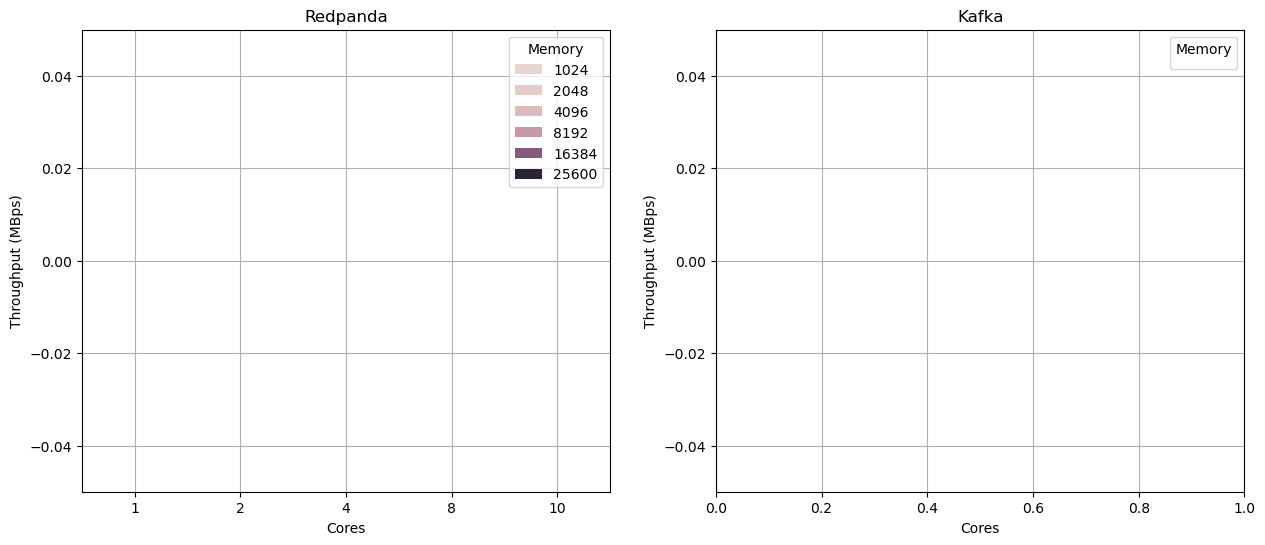

In [4]:
plot_throughput_vs_memory(ovhnvme_1)
# plot_throughput_vs_memory(ovhnvme_100)

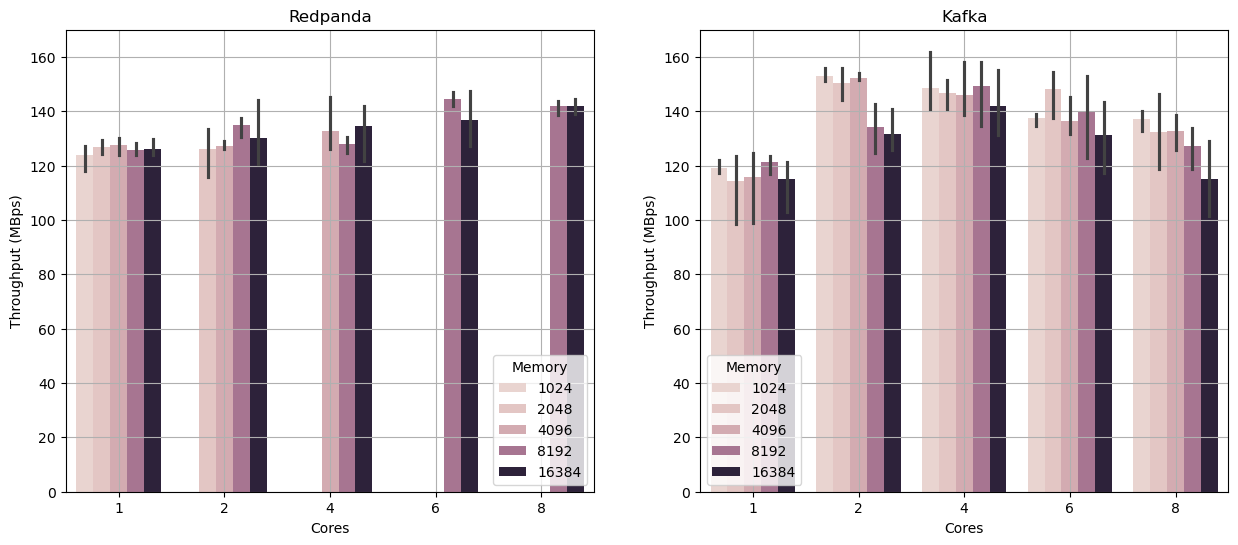

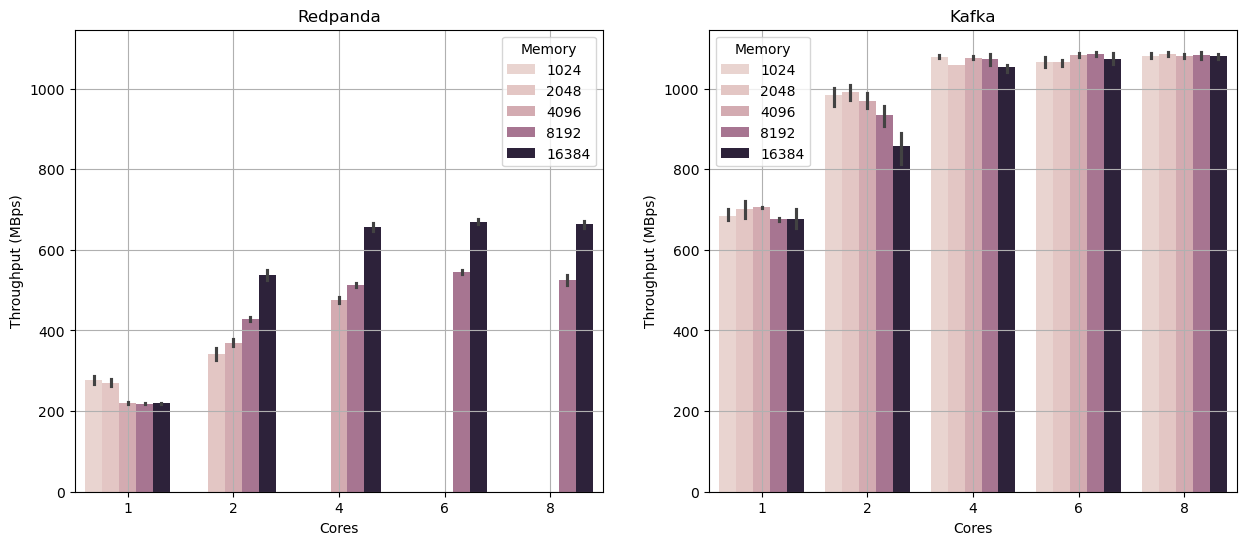

In [8]:
plot_throughput_vs_memory(grappe_1)
plot_throughput_vs_memory(grappe_100)

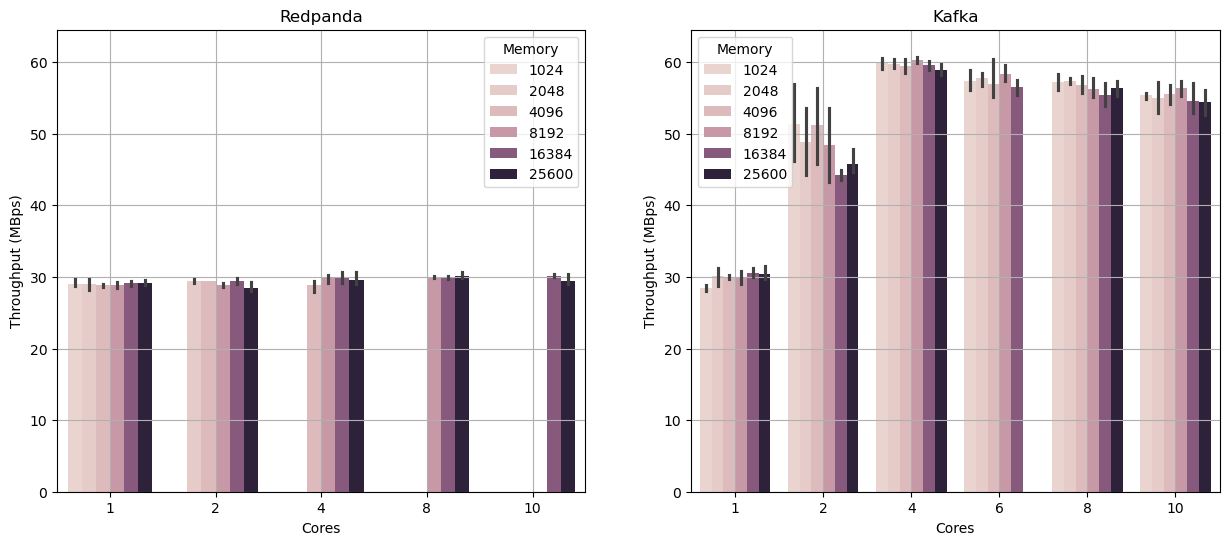

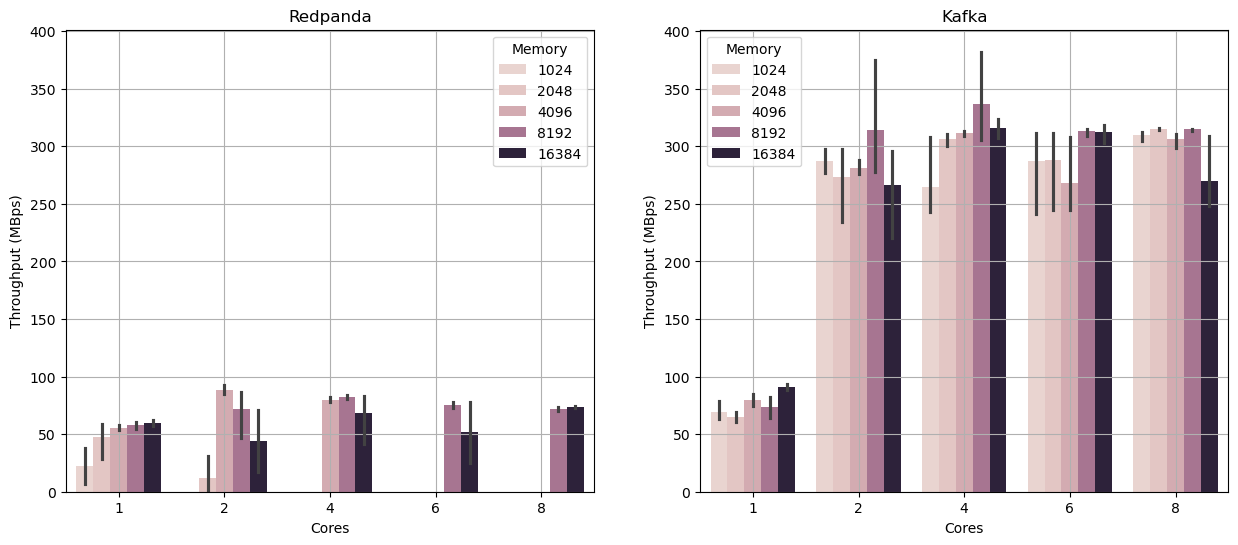

In [10]:
plot_throughput_vs_memory(taurus_1)
# an.create_qgrid_widget(taurus_100)
plot_throughput_vs_memory(taurus_100)